# Comparison of aviation climate models

In [1]:
import math
import numpy as np
import pandas as pd
import time
from pandas import read_csv
import matplotlib.pyplot as plt
from climate_models.fair_climate_model import background_species_quantities_function, species_fair_climate_model
from climate_models.climate_models import aviation_climate_model

# Sensitivity analysis
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib import ProblemSpec

## Parameters

In [2]:
scenario = "Historical"

In [3]:
commercial_aviation_historical_data_df = read_csv("climate_data/aviation_emissions_data.csv", delimiter=";")
commercial_aviation_historical_data = commercial_aviation_historical_data_df.values

if scenario == "Historical":
    years_data = commercial_aviation_historical_data[:80, 0]
    co2_emissions_data = commercial_aviation_historical_data[:80, 1]
    nox_emissions_data = commercial_aviation_historical_data[:80, 2]
    h2o_emissions_data = commercial_aviation_historical_data[:80, 3]
    soot_emissions_data = commercial_aviation_historical_data[:80, 4]
    sulfur_emissions_data = commercial_aviation_historical_data[:80, 5]
    distance_data = commercial_aviation_historical_data[:80, 6]
    
else:
    years_data = commercial_aviation_historical_data[:, 0]
    co2_emissions_data = commercial_aviation_historical_data[:, 1]
    nox_emissions_data = commercial_aviation_historical_data[:, 2]
    h2o_emissions_data = commercial_aviation_historical_data[:, 3]
    soot_emissions_data = commercial_aviation_historical_data[:, 4]
    sulfur_emissions_data = commercial_aviation_historical_data[:, 5]
    distance_data = commercial_aviation_historical_data[:, 6]

species_quantities = np.zeros((7, len(years_data)))

species_quantities[0] = co2_emissions_data * 1e9 # [Mt to kg]
species_quantities[1] = distance_data
species_quantities[2] = nox_emissions_data * 1e9 # [Mt to kg]
species_quantities[3] = nox_emissions_data * 1e9 # [Mt to kg]
species_quantities[4] = h2o_emissions_data * 1e9 # [Mt to kg]
species_quantities[5] = soot_emissions_data * 1e9 # [Mt to kg]
species_quantities[6] = sulfur_emissions_data * 1e9 # [Mt to kg]

if scenario == "Trend":
    pass
elif scenario == "Stabilisation":
    for i in range(0,7):
        for j in range(110, len(years_data)):
            species_quantities[i, j] = species_quantities[i, j-1] 
            
elif scenario == "Halt":
    for i in range(0,7):
        for j in range(110, len(years_data)):
            species_quantities[i, j] = 0  

start_year = int(years_data[0])
end_year = int(years_data[-1])

In [4]:
reference_temperature_data_df = read_csv("climate_data/reference_temperature_change_historic.csv", delimiter=";")
reference_temperature_data = reference_temperature_data_df.values
data_years = reference_temperature_data[:, 0]
data_temperature_grewe_curtech = reference_temperature_data[:, 1]
data_temperature_grewe_ecats = reference_temperature_data[:, 2]
data_temperature_klower = reference_temperature_data[:, 3]
data_temperature_klower_co2 = reference_temperature_data[:, 4]

In [5]:
background_species_quantities = background_species_quantities_function(start_year, end_year, rcp='RCP45')
sensitivity_rf_gwpstar = [0, 2.23e-12, 25.1e-12 * (14/46), -26.1e-12 * (14/46) * 0.77, 0.0052e-12, 100.7e-12, -19.9e-12]
sensitivity_rf_others = [0, 2.23e-12, 25.1e-12 * (14/46), -0.83e-9, 0.0052e-12, 100.7e-12, -19.9e-12]
ratio_erf_rf = [1, 0.42, 1.37, 1.18, 1, 1, 1]
efficacy_erf = [1, 1, 1, 1, 1, 1, 1]
tcre = 0.00045

species_settings_gwpstar = {"sensitivity_rf": sensitivity_rf_gwpstar, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}
species_settings_others = {"sensitivity_rf": sensitivity_rf_others, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}

model_settings_others = {"tcre": tcre}
model_settings_fair = {"background_species_quantities": background_species_quantities}

## Calculation

In [6]:
time1 = time.time()
gwpstar_climate_model = aviation_climate_model(start_year, end_year, "GWP*", species_quantities, species_settings_gwpstar, model_settings_others)
time2 = time.time()
lwe_climate_model = aviation_climate_model(start_year, end_year, "LWE", species_quantities, species_settings_others, model_settings_others)
time3 = time.time()
fair_climate_model = aviation_climate_model(start_year, end_year, "FaIR", species_quantities, species_settings_others, model_settings_fair)
time4 = time.time()
fair2_climate_model = aviation_climate_model(start_year, end_year, species_fair_climate_model, species_quantities, species_settings_others, model_settings_fair)
time5 = time.time()
print("GWP*:", time2-time1, "s")
print("LWE:", time3-time2 ,"s")
print("FaIR:", time4-time3, "s")
print("FaIR (manual):", time5-time4, "s")

The chosen climate model is directly provided or not available in AeroMAPS.
GWP*: 0.12630844116210938 s
LWE: 1.9765472412109375 s
FaIR: 6.748432159423828 s
FaIR (manual): 9.903358221054077 s


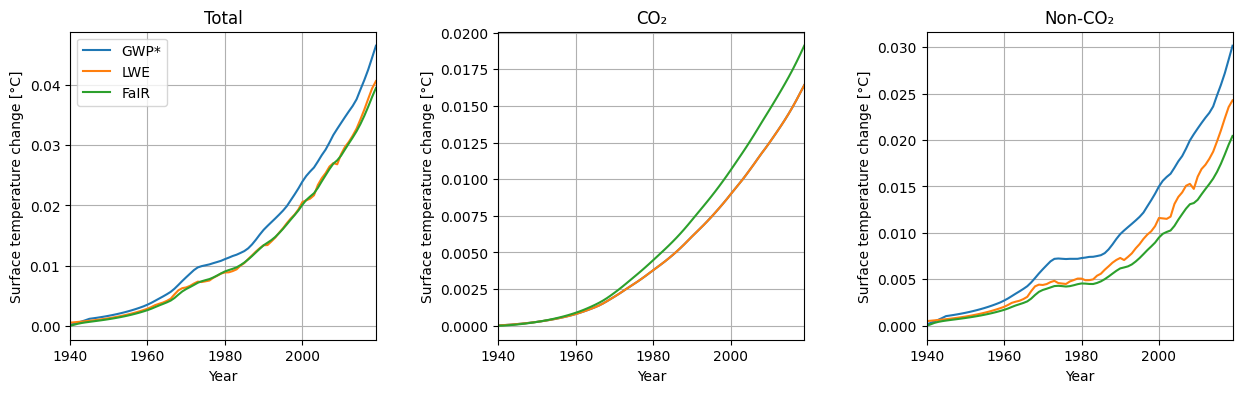

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

plt.subplots_adjust(wspace=0.4)

for i, ax in enumerate(axes.flat):
    if i == 0:
        ax.plot(years_data, gwpstar_climate_model[-1], label='GWP*')
        ax.plot(years_data, lwe_climate_model[-1], label='LWE')
        ax.plot(years_data, fair_climate_model[-1], label='FaIR')
        ax.legend()
        ax.grid()
        ax.set_title('Total')
    elif i == 1:
        ax.plot(years_data, gwpstar_climate_model[2], label='GWP*')
        ax.plot(years_data, lwe_climate_model[2], label='LWE')
        ax.plot(years_data, fair_climate_model[2], label='FaIR')
        ax.grid()
        ax.set_title('CO₂')
    else:
        ax.plot(years_data, gwpstar_climate_model[-4], label='GWP*')
        ax.plot(years_data, lwe_climate_model[-4], label='LWE')
        ax.plot(years_data, fair_climate_model[-4], label='FaIR')
        ax.grid()
        ax.set_title('Non-CO₂')
    
    ax.set_xlim(start_year,end_year)
    ax.set_xlabel('Year')
    ax.set_ylabel('Surface temperature change [°C]')


plt.show()

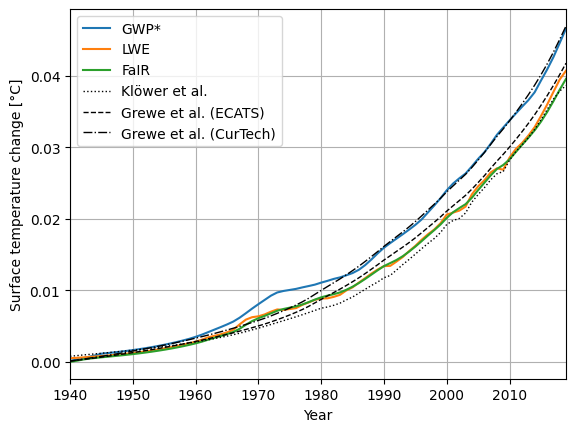

In [8]:
plt.plot(years_data, gwpstar_climate_model[-1], label='GWP*')
plt.plot(years_data, lwe_climate_model[-1], label='LWE')
plt.plot(years_data, fair_climate_model[-1], label='FaIR')
plt.plot(years_data, data_temperature_klower[0:2019-1940+1]/1000, label='Klöwer et al.', color='black', linestyle =":", linewidth=1)
plt.plot(years_data, data_temperature_grewe_ecats[0:2019-1940+1]/1000, label='Grewe et al. (ECATS)', color='black', linestyle ="--", linewidth=1)
plt.plot(years_data, data_temperature_grewe_curtech[0:2019-1940+1]/1000, label='Grewe et al. (CurTech)', color='black', linestyle ="-.", linewidth=1)
# plt.plot(years_data, lwe_climate_model[2], label='CO₂ only', color='black', linestyle ="-")

plt.legend()
plt.grid()
plt.xlim(1940,2019)
plt.xlabel('Year')
plt.ylabel('Surface temperature change [°C]')
plt.show()

In [17]:
# Define problem
sp = ProblemSpec({
    'names': ['sensitivity_rf', 'ratio_erf_rf', 'efficacy_erf'],
    'bounds': [ 
        [2.23e-12, 7.96e-13],
        #[0.31, 0.59], 
        [0.23, 0.87], 
        [0.12, 0.64], 
    ],
    'dists': ['norm', 'unif', 'unif'],
})

In [18]:
# Create wrapper for function

def wrapped_model(params):
    n_samples = params.shape[0]
    n_times = end_year - start_year + 1
    results = np.empty((n_samples, n_times))

    for i in range(n_samples):
        sensitivity_rf_others = [0, params[i,0], 25.1e-12 * (14/46), -0.83e-9, 0.0052e-12, 100.7e-12, -19.9e-12]
        ratio_erf_rf = [1, params[i,1], 1.37, 1.18, 1, 1, 1]
        efficacy_erf = [1, params[i,2], 1, 1, 1, 1, 1]
        species_settings_others = {"sensitivity_rf": sensitivity_rf_others, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}
        results[i, :] = aviation_climate_model(start_year, end_year, "FaIR", species_quantities, species_settings_others, model_settings_fair)[-1].flatten()
    
    return results

# Run all steps
nb_samples = 16 # 2 ** (n_samples+1)
(
    sp.sample_sobol(nb_samples, calc_second_order=False)  
    .evaluate(wrapped_model)
    .analyze_sobol()
)

C:\Users\t.planes\AppData\Local\miniconda3\envs\AeroMetrics\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
C:\Users\t.planes\AppData\Local\miniconda3\envs\AeroMetrics\lib\site-packages\SALib\analyze\sobol.py:141: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()
C:\Users\t.planes\AppData\Local\miniconda3\envs\AeroMetrics\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
C:\Users\t.planes\AppData\Local\miniconda3\envs\AeroMetrics\lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise

Samples:
	3 parameters: ['sensitivity_rf', 'ratio_erf_rf', 'efficacy_erf']
	80 samples
Outputs:
	80 outputs: ['Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'Y17', 'Y18', 'Y19', 'Y20', 'Y21', 'Y22', 'Y23', 'Y24', 'Y25', 'Y26', 'Y27', 'Y28', 'Y29', 'Y30', 'Y31', 'Y32', 'Y33', 'Y34', 'Y35', 'Y36', 'Y37', 'Y38', 'Y39', 'Y40', 'Y41', 'Y42', 'Y43', 'Y44', 'Y45', 'Y46', 'Y47', 'Y48', 'Y49', 'Y50', 'Y51', 'Y52', 'Y53', 'Y54', 'Y55', 'Y56', 'Y57', 'Y58', 'Y59', 'Y60', 'Y61', 'Y62', 'Y63', 'Y64', 'Y65', 'Y66', 'Y67', 'Y68', 'Y69', 'Y70', 'Y71', 'Y72', 'Y73', 'Y74', 'Y75', 'Y76', 'Y77', 'Y78', 'Y79', 'Y80']
	80 evaluations
Analysis:
Y1:
                ST  ST_conf
sensitivity_rf NaN      NaN
ratio_erf_rf   NaN      NaN
efficacy_erf   NaN      NaN:
                S1  S1_conf
sensitivity_rf NaN      NaN
ratio_erf_rf   NaN      NaN
efficacy_erf   NaN      NaN:
                                S2  S2_conf
(sensitivity_rf, ratio_erf_rf) NaN     

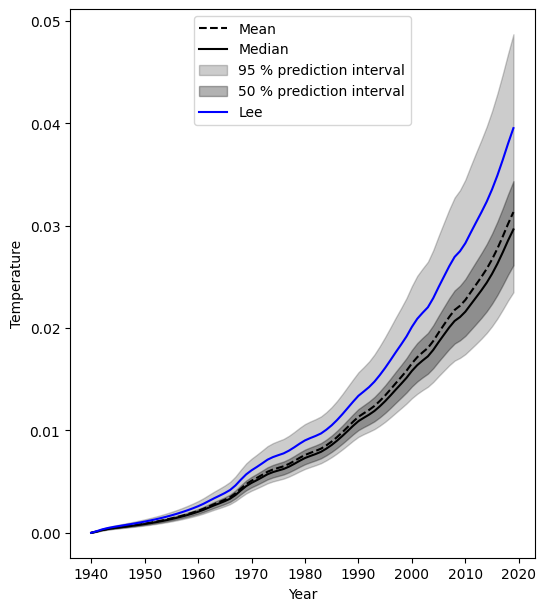

In [19]:
# Get first order sensitivities for all outputs
S1s = np.array([sp.analysis[_y]['S1'] for _y in sp['outputs']])

# Get model outputs (each output is a given time horizon)
y = sp.results

# Set up figure
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(3, 2)

ax0 = fig.add_subplot(gs[:, 0])

ax0.plot(years_data, np.mean(y, axis=0), label="Mean", color='black', linestyle='--')

ax0.plot(years_data, np.median(y, axis=0), label="Median", color='black')

# in percent
prediction_interval = 95

ax0.fill_between(years_data,
                 np.percentile(y, 50 - prediction_interval/2., axis=0),
                 np.percentile(y, 50 + prediction_interval/2., axis=0),
                 alpha=0.2, color='black',
                 label=f"{prediction_interval} % prediction interval")

prediction_interval = 50
ax0.fill_between(years_data,
                 np.percentile(y, 50 - prediction_interval/2., axis=0),
                 np.percentile(y, 50 + prediction_interval/2., axis=0),
                 alpha=0.3, color='black',
                 label=f"{prediction_interval} % prediction interval")

ax0.plot(years_data, fair_climate_model[-1], label="Lee", color='blue')

ax0.set_xlabel("Year")
ax0.set_ylabel("Temperature")
ax0.legend(loc='upper center')._legend_box.align = "left"

plt.show()